In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from tqdm import tqdm
import csv


two_links_file = r"C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\ScenarioData\TwoLinks\combined_TwoLinks_with_coords.csv"
single_links_file = r"C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\OiDj_merged.csv"
output_file = r"C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\ScenarioData\two_links_results_1.csv"


two_links_df = pd.read_csv(two_links_file)
single_links_df = pd.read_csv(single_links_file)

# Data cleaning: remove data where net_mode_0 is null and remove data where net_i_0 equals net_j_0 equals net_j_1
two_links_df = two_links_df.dropna(subset=['net_mode_0'])
two_links_df = two_links_df[~((two_links_df['net_i_0'] == two_links_df['net_j_0']) & (two_links_df['net_j_0'] == two_links_df['net_j_1']))]

impact_columns = {0: 'CkDiffRoad', 1: 'CkDiffBus', 2: 'CkDiffRail'}

# Creating a square buffer
def create_square_buffer(center_lat, center_lon, side_length_km=10):
    delta_lat = side_length_km / 111  
    delta_lon = side_length_km / (111 * np.cos(np.deg2rad(center_lat)))
    return {
        'min_lat': center_lat - delta_lat / 2,
        'max_lat': center_lat + delta_lat / 2,
        'min_lon': center_lon - delta_lon / 2,
        'max_lon': center_lon + delta_lon / 2
    }

# filtering one-link scenarios in the buffer
def filter_single_link_scenarios(buffer, single_link_scenarios):
    return single_link_scenarios[
        (single_link_scenarios['lat_neti'] >= buffer['min_lat']) &
        (single_link_scenarios['lat_neti'] <= buffer['max_lat']) &
        (single_link_scenarios['lon_neti'] >= buffer['min_lon']) &
        (single_link_scenarios['lon_neti'] <= buffer['max_lon']) &
        (single_link_scenarios['lat_netj'] >= buffer['min_lat']) &
        (single_link_scenarios['lat_netj'] <= buffer['max_lat']) &
        (single_link_scenarios['lon_netj'] >= buffer['min_lon']) &
        (single_link_scenarios['lon_netj'] <= buffer['max_lon'])
    ]

# Calculate impact values for single link combinations
def calculate_combinations(single_link_scenarios, impact_column):
    impacts = single_link_scenarios[impact_column].values
    combinations_impacts = [impacts[i] + impacts[j] for i, j in combinations(range(len(impacts)), 2)]
    return combinations_impacts


with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=['id', 'idx', 'impact', 'percentile', 'mode', 'num_combinations'])
    writer.writeheader()

# Processing two-link scenarios
for i, row in tqdm(two_links_df.iterrows(), total=two_links_df.shape[0], desc="Processing Two Links"):

    center_lat = row['lat_j_0']
    center_lon = row['lon_j_0']
    net_mode = row['net_mode_0']
    impact_column = impact_columns[int(net_mode)]
    two_link_impact = row[impact_column]
    buffer = create_square_buffer(center_lat, center_lon)
    
    # Filtering single-link scenarios in the buffer
    filtered_single_links = single_links_df[single_links_df['net_mode'] == net_mode]
    single_links_in_buffer = filter_single_link_scenarios(buffer, filtered_single_links)
    
    if single_links_in_buffer.empty:
        percentile = 0
        num_combinations = 0
    else:
        # Calculate the impact value for each combination
        combinations_impacts = calculate_combinations(single_links_in_buffer, impact_column)
        num_combinations = len(combinations_impacts)
        if num_combinations > 0:
            percentile = (np.sum(np.array(combinations_impacts) < two_link_impact) / num_combinations) * 100
        else:
            percentile = 0
    
    result = {
        'id': row['net_j_0'],
        'idx': row['idx'],
        'impact': two_link_impact,
        'percentile': percentile,
        'mode': net_mode,
        'num_combinations': num_combinations
    }
    
    with open(output_file, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=['id', 'idx', 'impact', 'percentile', 'mode', 'num_combinations'])
        writer.writerow(result)


Processing Two Links:  96%|█████████▋| 247616/257056 [23:29:04<33:59,  4.63it/s]    

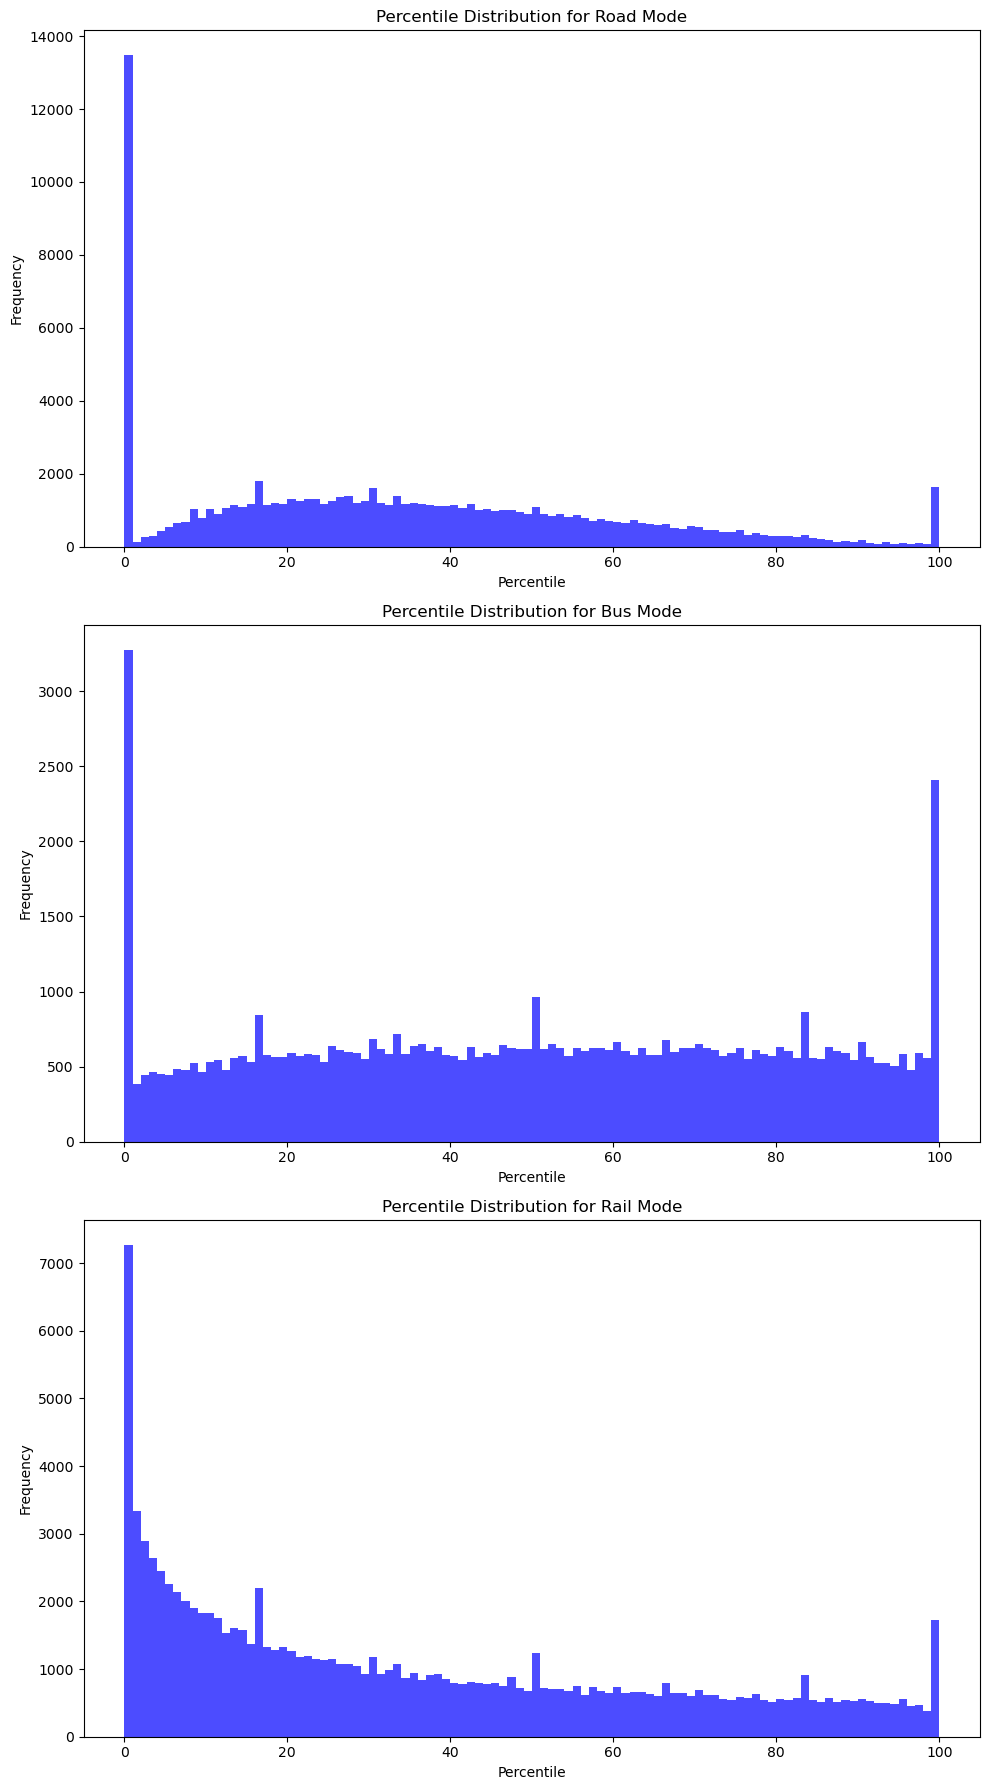

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations
from tqdm import tqdm
import csv

results_df = pd.read_csv(r"C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\ScenarioData\two_links_results_1.csv")
fig, axs = plt.subplots(3, 1, figsize=(10, 18))
modes = {0: 'Road', 1: 'Bus', 2: 'Rail'}
for i, mode in enumerate(modes.keys()):
    mode_data = results_df[results_df['mode'] == mode]
    axs[i].hist(mode_data['percentile'], bins=100, alpha=0.7, color='blue')
    axs[i].set_title(f'Percentile Distribution for {modes[mode]} Mode')
    axs[i].set_xlabel('Percentile')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig("percentile_distributions.png")
plt.show()

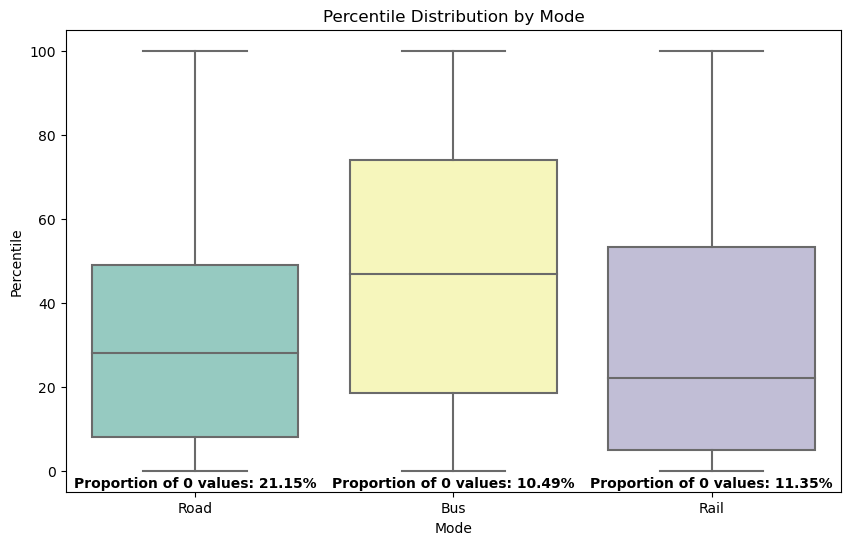

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the percentage of percentile 0's in each mode
percentile_zeros = results_df[results_df['percentile'] == 0].groupby('mode').size() / results_df.groupby('mode').size()

plt.figure(figsize=(10, 6))
sns.boxplot(x='mode', y='percentile', data=results_df, palette="Set3")
plt.xlabel('Mode')
plt.ylabel('Percentile')
plt.title('Percentile Distribution by Mode')
plt.xticks(ticks=[0, 1, 2], labels=['Road', 'Bus', 'Rail'])

# Percentage of 0 values labelled on the graphs
for mode, proportion in percentile_zeros.items():
    plt.text(mode, results_df['percentile'].min() -4 , f'Proportion of 0 values: {proportion:.2%}', 
             horizontalalignment='center', size='medium', color='black', weight='semibold')
plt.show()


In [10]:
import pandas as pd
from tqdm import tqdm
import csv

two_links_file = r"C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\ScenarioData\TwoLinks\combined_TwoLinks_with_coords.csv"
single_links_file = r"C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\OiDj_merged.csv"
output_file = r"C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\ScenarioData\single_vs_double_links_results.csv"

two_links_df = pd.read_csv(two_links_file)
single_links_df = pd.read_csv(single_links_file)

# Clean NA values
two_links_df = two_links_df.dropna(subset=['net_mode_0'])


impact_columns = {0: 'CkDiffRoad', 1: 'CkDiffBus', 2: 'CkDiffRail'}

with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=[
        'idx', 'net_i_0', 'net_j_0', 'net_j_1', 'double_mode', 'double_impact',
        'single_net_i_1', 'single_net_j_1', 'single_mode_1', 'single_impact_1',
        'single_net_i_2', 'single_net_j_2', 'single_mode_2', 'single_impact_2',
        'impact_difference'
    ])
    writer.writeheader()

# Dual-link scenario 
for i, row in tqdm(two_links_df.iterrows(), total=two_links_df.shape[0], desc="Processing Two Links"):

    idx = row['idx']
    net_i_0 = row['net_i_0']
    net_j_0 = row['net_j_0']
    net_j_1 = row['net_j_1']
    net_mode = row['net_mode_0']
    impact_column = impact_columns[int(net_mode)]
    double_impact = row[impact_column]
    
    # Find the corresponding single link pair
    single_links_ab = single_links_df[
        (single_links_df['net_i'] == net_i_0) &
        (single_links_df['net_j'] == net_j_0)
    ]
    
    single_links_bc = single_links_df[
        (single_links_df['net_i'] == net_j_0) &
        (single_links_df['net_j'] == net_j_1)
    ]
    
    # Calculate the sum of the impact values for all single-link combinations and compare them to the impact values for the double-link scenarios
    for _, ab_row in single_links_ab.iterrows():
        for _, bc_row in single_links_bc.iterrows():
            single_impact_1 = ab_row[impact_columns[int(ab_row['net_mode'])]]
            single_impact_2 = bc_row[impact_columns[int(bc_row['net_mode'])]]
            impact_difference = double_impact - (single_impact_1 + single_impact_2)
            
            # write to CSV
            result = {
                'idx': idx,
                'net_i_0': net_i_0,
                'net_j_0': net_j_0,
                'net_j_1': net_j_1,
                'double_mode': net_mode,
                'double_impact': double_impact,
                'single_net_i_1': net_i_0,
                'single_net_j_1': net_j_0,
                'single_mode_1': ab_row['net_mode'],
                'single_impact_1': single_impact_1,
                'single_net_i_2': net_j_0,
                'single_net_j_2': net_j_1,
                'single_mode_2': bc_row['net_mode'],
                'single_impact_2': single_impact_2,
                'impact_difference': impact_difference
            }
            
            with open(output_file, mode='a', newline='', encoding='utf-8') as file:
                writer = csv.DictWriter(file, fieldnames=[
                    'idx', 'net_i_0', 'net_j_0', 'net_j_1', 'double_mode', 'double_impact',
                    'single_net_i_1', 'single_net_j_1', 'single_mode_1', 'single_impact_1',
                    'single_net_i_2', 'single_net_j_2', 'single_mode_2', 'single_impact_2',
                    'impact_difference'
                ])
                writer.writerow(result)


Processing Two Links: 100%|██████████| 281925/281925 [34:34<00:00, 135.88it/s]


In [3]:
import pandas as pd
from tqdm import tqdm
import csv

two_links_file = r"C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\ScenarioData\TwoLinks\combined_TwoLinks_with_coords.csv"
single_links_file = r"C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\OiDj_merged.csv"
output_file = r"C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\ScenarioData\single_vs_double_links_results_1.csv"

two_links_df = pd.read_csv(two_links_file)
single_links_df = pd.read_csv(single_links_file)

# Clean NA values
two_links_df = two_links_df.dropna(subset=['net_mode_0'])

impact_columns = {
    0: 'CkDiffRoad',
    1: 'CkDiffBus',
    2: 'CkDiffRail'
}

nminus_columns = {
    0: 'nMinusRoad',
    1: 'nMinusBus',
    2: 'nMinusRail'
}

savedsecs_columns = {
    0: 'SavedSecsRoad',
    1: 'SavedSecsBus',
    2: 'SavedSecsRail'
}

with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=[
        'idx', 'net_i_0', 'net_j_0', 'net_j_1', 'double_mode', 'double_impact', 'double_nminus', 'double_savedsecs',
        'single_net_i_1', 'single_net_j_1', 'single_mode_1', 'single_impact_1', 'single_nminus_1', 'single_savedsecs_1',
        'single_net_i_2', 'single_net_j_2', 'single_mode_2', 'single_impact_2', 'single_nminus_2', 'single_savedsecs_2',
        'impact_difference'
    ])
    writer.writeheader()

for i, row in tqdm(two_links_df.iterrows(), total=two_links_df.shape[0], desc="Processing Two Links"):
    idx = row['idx']
    net_i_0 = row['net_i_0']
    net_j_0 = row['net_j_0']
    net_j_1 = row['net_j_1']
    net_mode = row['net_mode_0']
    impact_column = impact_columns[int(net_mode)]
    nminus_column = nminus_columns[int(net_mode)]
    savedsecs_column = savedsecs_columns[int(net_mode)]
    double_impact = row[impact_column]
    double_nminus = row[nminus_column]
    double_savedsecs = row[savedsecs_column]

    # Find the corresponding single link pair with the same mode
    single_links_ab = single_links_df[
        (single_links_df['net_i'] == net_i_0) &
        (single_links_df['net_j'] == net_j_0) &
        (single_links_df['net_mode'] == net_mode)
    ]

    single_links_bc = single_links_df[
        (single_links_df['net_i'] == net_j_0) &
        (single_links_df['net_j'] == net_j_1) &
        (single_links_df['net_mode'] == net_mode)
    ]

    for _, ab_row in single_links_ab.iterrows():
        for _, bc_row in single_links_bc.iterrows():
            single_impact_1 = ab_row[impact_columns[int(ab_row['net_mode'])]]
            single_impact_2 = bc_row[impact_columns[int(bc_row['net_mode'])]]
            single_nminus_1 = ab_row[nminus_columns[int(ab_row['net_mode'])]]
            single_nminus_2 = bc_row[nminus_columns[int(bc_row['net_mode'])]]
            single_savedsecs_1 = ab_row[savedsecs_columns[int(ab_row['net_mode'])]]
            single_savedsecs_2 = bc_row[savedsecs_columns[int(bc_row['net_mode'])]]
            impact_difference = double_impact - (single_impact_1 + single_impact_2)

            result = {
                'idx': idx,
                'net_i_0': net_i_0,
                'net_j_0': net_j_0,
                'net_j_1': net_j_1,
                'double_mode': net_mode,
                'double_impact': double_impact,
                'double_nminus': double_nminus,
                'double_savedsecs': double_savedsecs,
                'single_net_i_1': net_i_0,
                'single_net_j_1': net_j_0,
                'single_mode_1': ab_row['net_mode'],
                'single_impact_1': single_impact_1,
                'single_nminus_1': single_nminus_1,
                'single_savedsecs_1': single_savedsecs_1,
                'single_net_i_2': net_j_0,
                'single_net_j_2': net_j_1,
                'single_mode_2': bc_row['net_mode'],
                'single_impact_2': single_impact_2,
                'single_nminus_2': single_nminus_2,
                'single_savedsecs_2': single_savedsecs_2,
                'impact_difference': impact_difference
            }

            with open(output_file, mode='a', newline='', encoding='utf-8') as file:
                writer = csv.DictWriter(file, fieldnames=[
                    'idx', 'net_i_0', 'net_j_0', 'net_j_1', 'double_mode', 'double_impact', 'double_nminus', 'double_savedsecs',
                    'single_net_i_1', 'single_net_j_1', 'single_mode_1', 'single_impact_1', 'single_nminus_1', 'single_savedsecs_1',
                    'single_net_i_2', 'single_net_j_2', 'single_mode_2', 'single_impact_2', 'single_nminus_2', 'single_savedsecs_2',
                    'impact_difference'
                ])
                writer.writerow(result)


Processing Two Links: 100%|██████████| 281925/281925 [15:42<00:00, 299.28it/s]


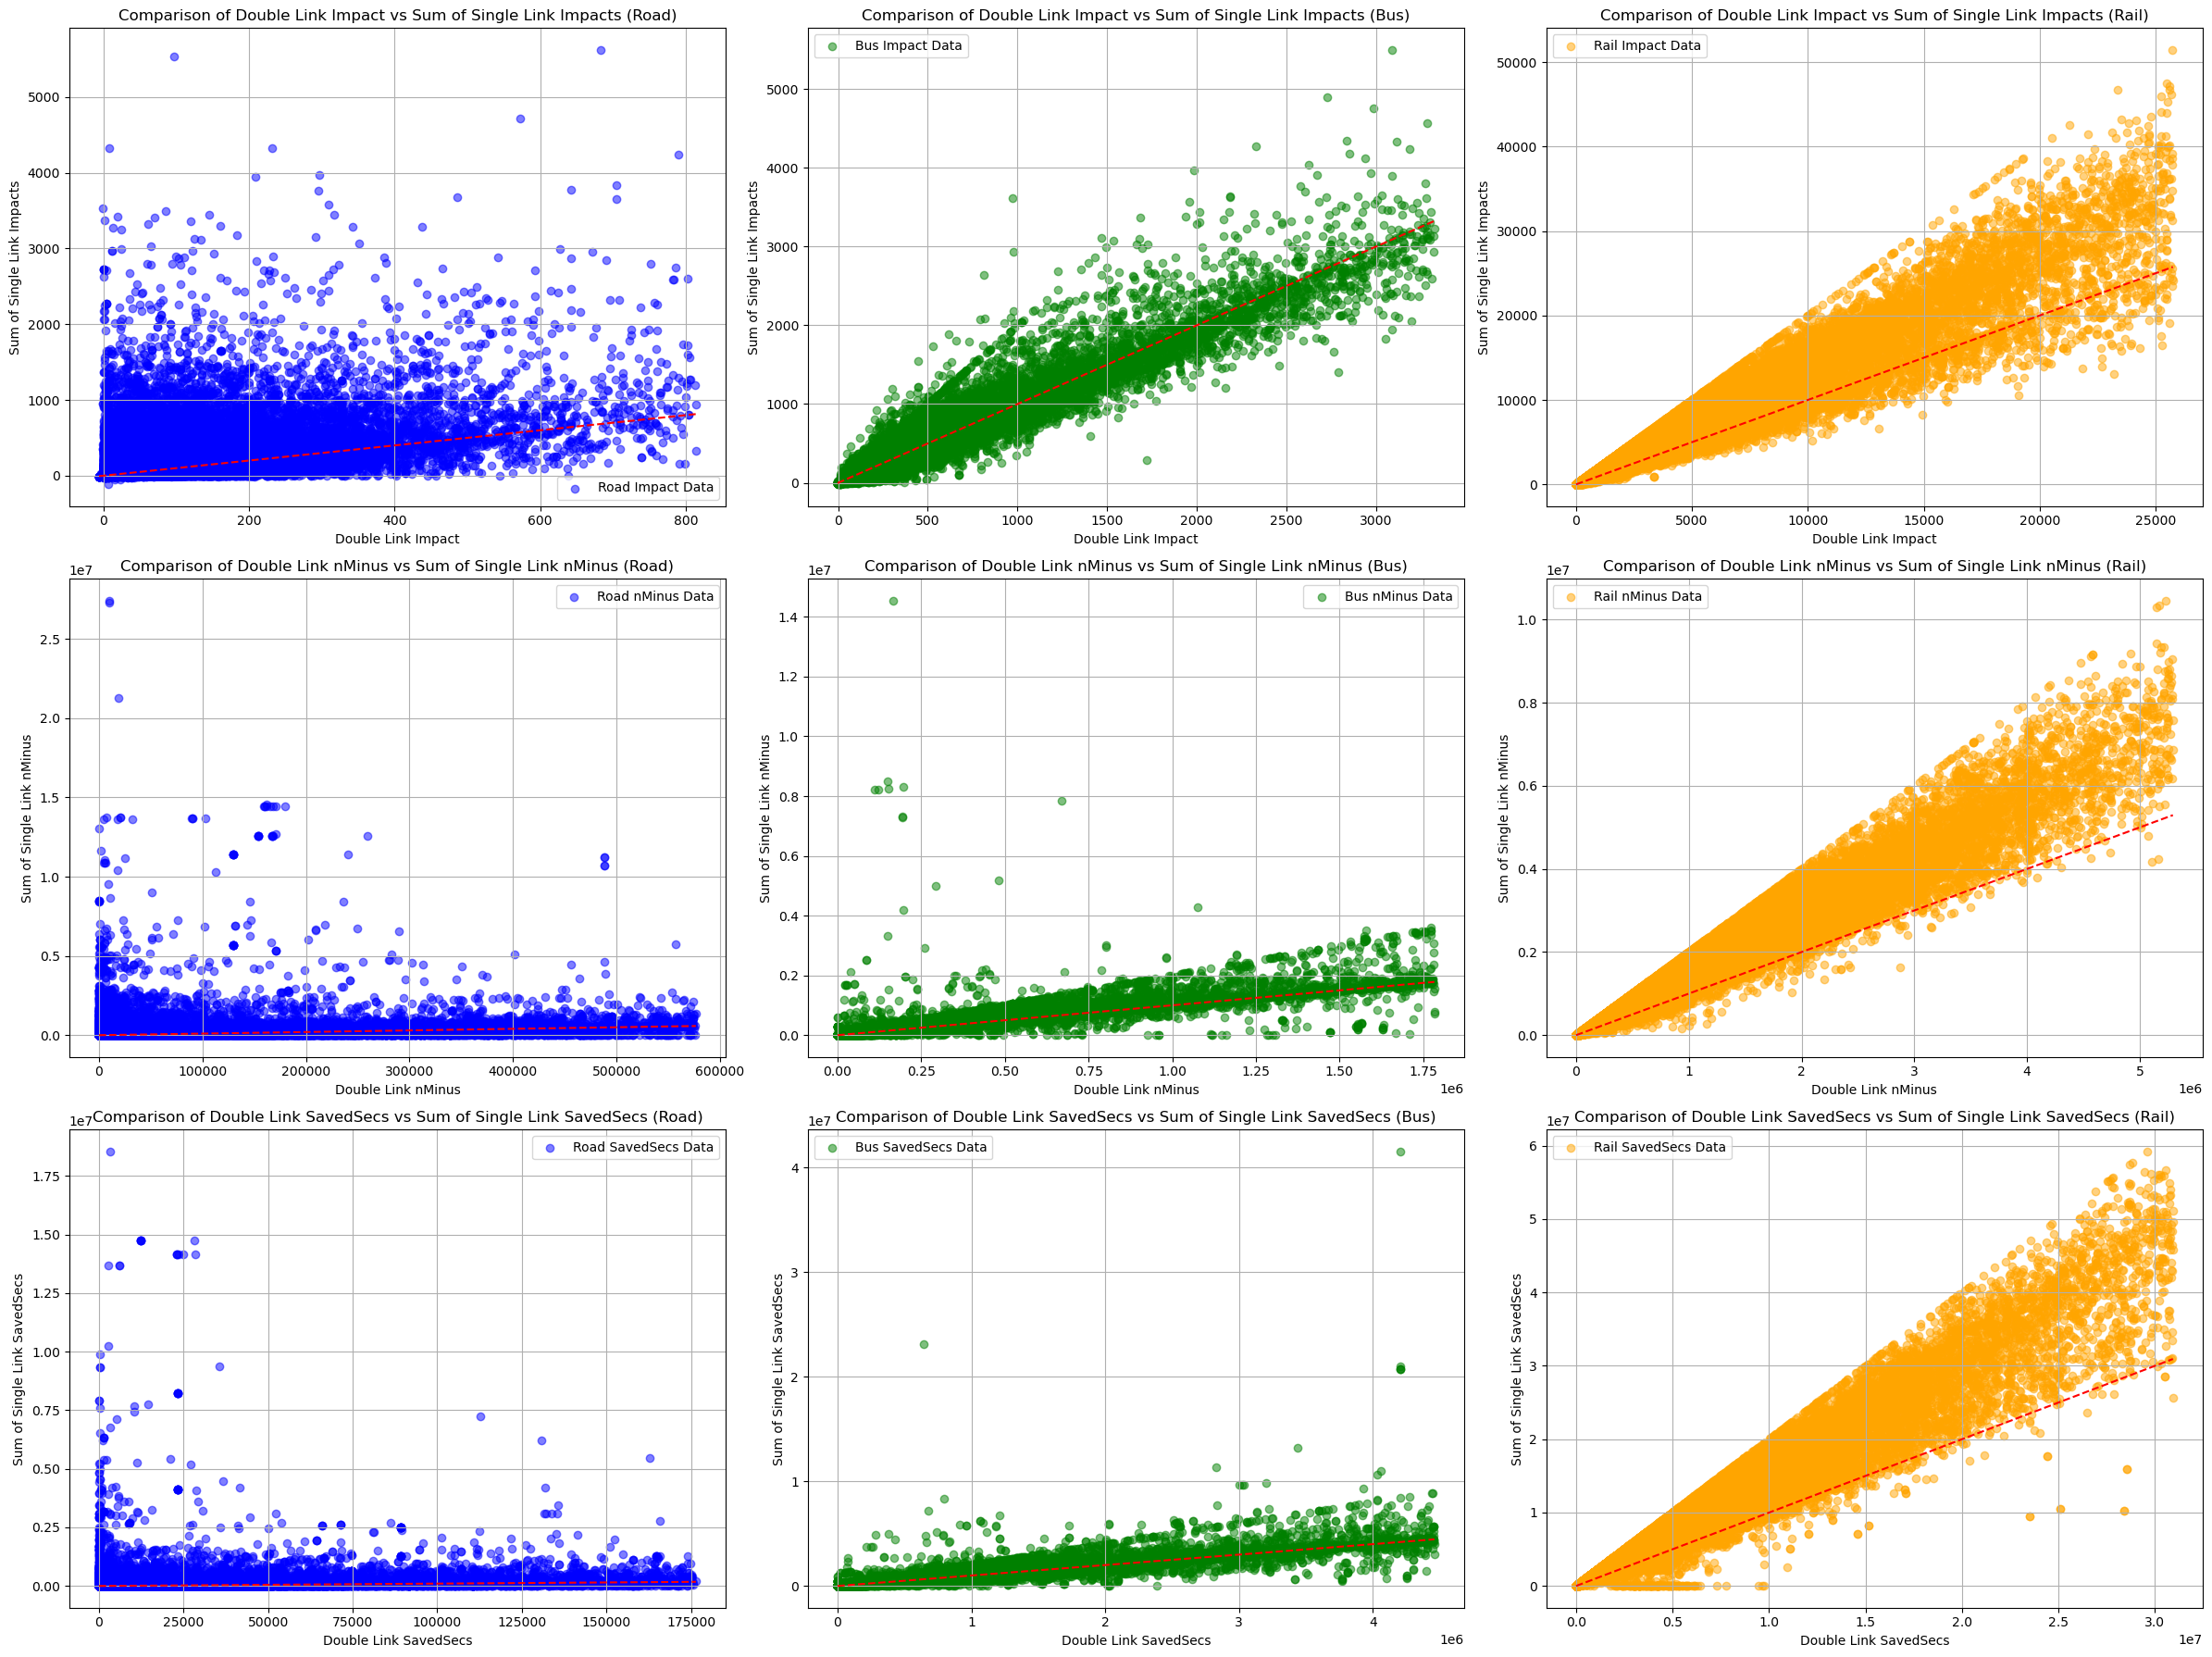

In [6]:
# Plotting using raw data but filtering extreme values
import pandas as pd
import matplotlib.pyplot as plt

output_file = r"C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\ScenarioData\single_vs_double_links_results_1.csv"
df = pd.read_csv(output_file)

# Adding combined columns for sum calculations
df['single_impact_sum'] = df['single_impact_1'] + df['single_impact_2']
df['single_nminus_sum'] = df['single_nminus_1'] + df['single_nminus_2']
df['single_savedsecs_sum'] = df['single_savedsecs_1'] + df['single_savedsecs_2']

fig, axes = plt.subplots(3, 3, figsize=(24, 18))

modes = {0: 'Road', 1: 'Bus', 2: 'Rail'}
colors = {0: 'blue', 1: 'green', 2: 'orange'}

# Function to filter out extreme values
def filter_extreme_values(df, column, factor=10):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (factor * iqr)
    upper_bound = q3 + (factor * iqr)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Impact
for mode, label in modes.items():
    ax = axes[0, mode]
    mode_df = df[df['double_mode'] == mode]
    filtered_df = filter_extreme_values(mode_df, 'double_impact')
    ax.scatter(filtered_df['double_impact'], filtered_df['single_impact_sum'], alpha=0.5, color=colors[mode], label=f'{label} Impact Data')
    ax.plot([filtered_df['double_impact'].min(), filtered_df['double_impact'].max()],
            [filtered_df['double_impact'].min(), filtered_df['double_impact'].max()],
            color='red', linestyle='--')
    ax.set_xlabel('Double Link Impact')
    ax.set_ylabel('Sum of Single Link Impacts')
    ax.set_title(f'Comparison of Double Link Impact vs Sum of Single Link Impacts ({label})')
    ax.legend()
    ax.grid(True)

# nMinus
for mode, label in modes.items():
    ax = axes[1, mode]
    mode_df = df[df['double_mode'] == mode]
    filtered_df = filter_extreme_values(mode_df, 'double_nminus')
    ax.scatter(filtered_df['double_nminus'], filtered_df['single_nminus_sum'], alpha=0.5, color=colors[mode], label=f'{label} nMinus Data')
    ax.plot([filtered_df['double_nminus'].min(), filtered_df['double_nminus'].max()],
            [filtered_df['double_nminus'].min(), filtered_df['double_nminus'].max()],
            color='red', linestyle='--')
    ax.set_xlabel('Double Link nMinus')
    ax.set_ylabel('Sum of Single Link nMinus')
    ax.set_title(f'Comparison of Double Link nMinus vs Sum of Single Link nMinus ({label})')
    ax.legend()
    ax.grid(True)

# SavedSecs
for mode, label in modes.items():
    ax = axes[2, mode]
    mode_df = df[df['double_mode'] == mode]
    filtered_df = filter_extreme_values(mode_df, 'double_savedsecs')
    ax.scatter(filtered_df['double_savedsecs'], filtered_df['single_savedsecs_sum'], alpha=0.5, color=colors[mode], label=f'{label} SavedSecs Data')
    ax.plot([filtered_df['double_savedsecs'].min(), filtered_df['double_savedsecs'].max()],
            [filtered_df['double_savedsecs'].min(), filtered_df['double_savedsecs'].max()],
            color='red', linestyle='--')
    ax.set_xlabel('Double Link SavedSecs')
    ax.set_ylabel('Sum of Single Link SavedSecs')
    ax.set_title(f'Comparison of Double Link SavedSecs vs Sum of Single Link SavedSecs ({label})')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


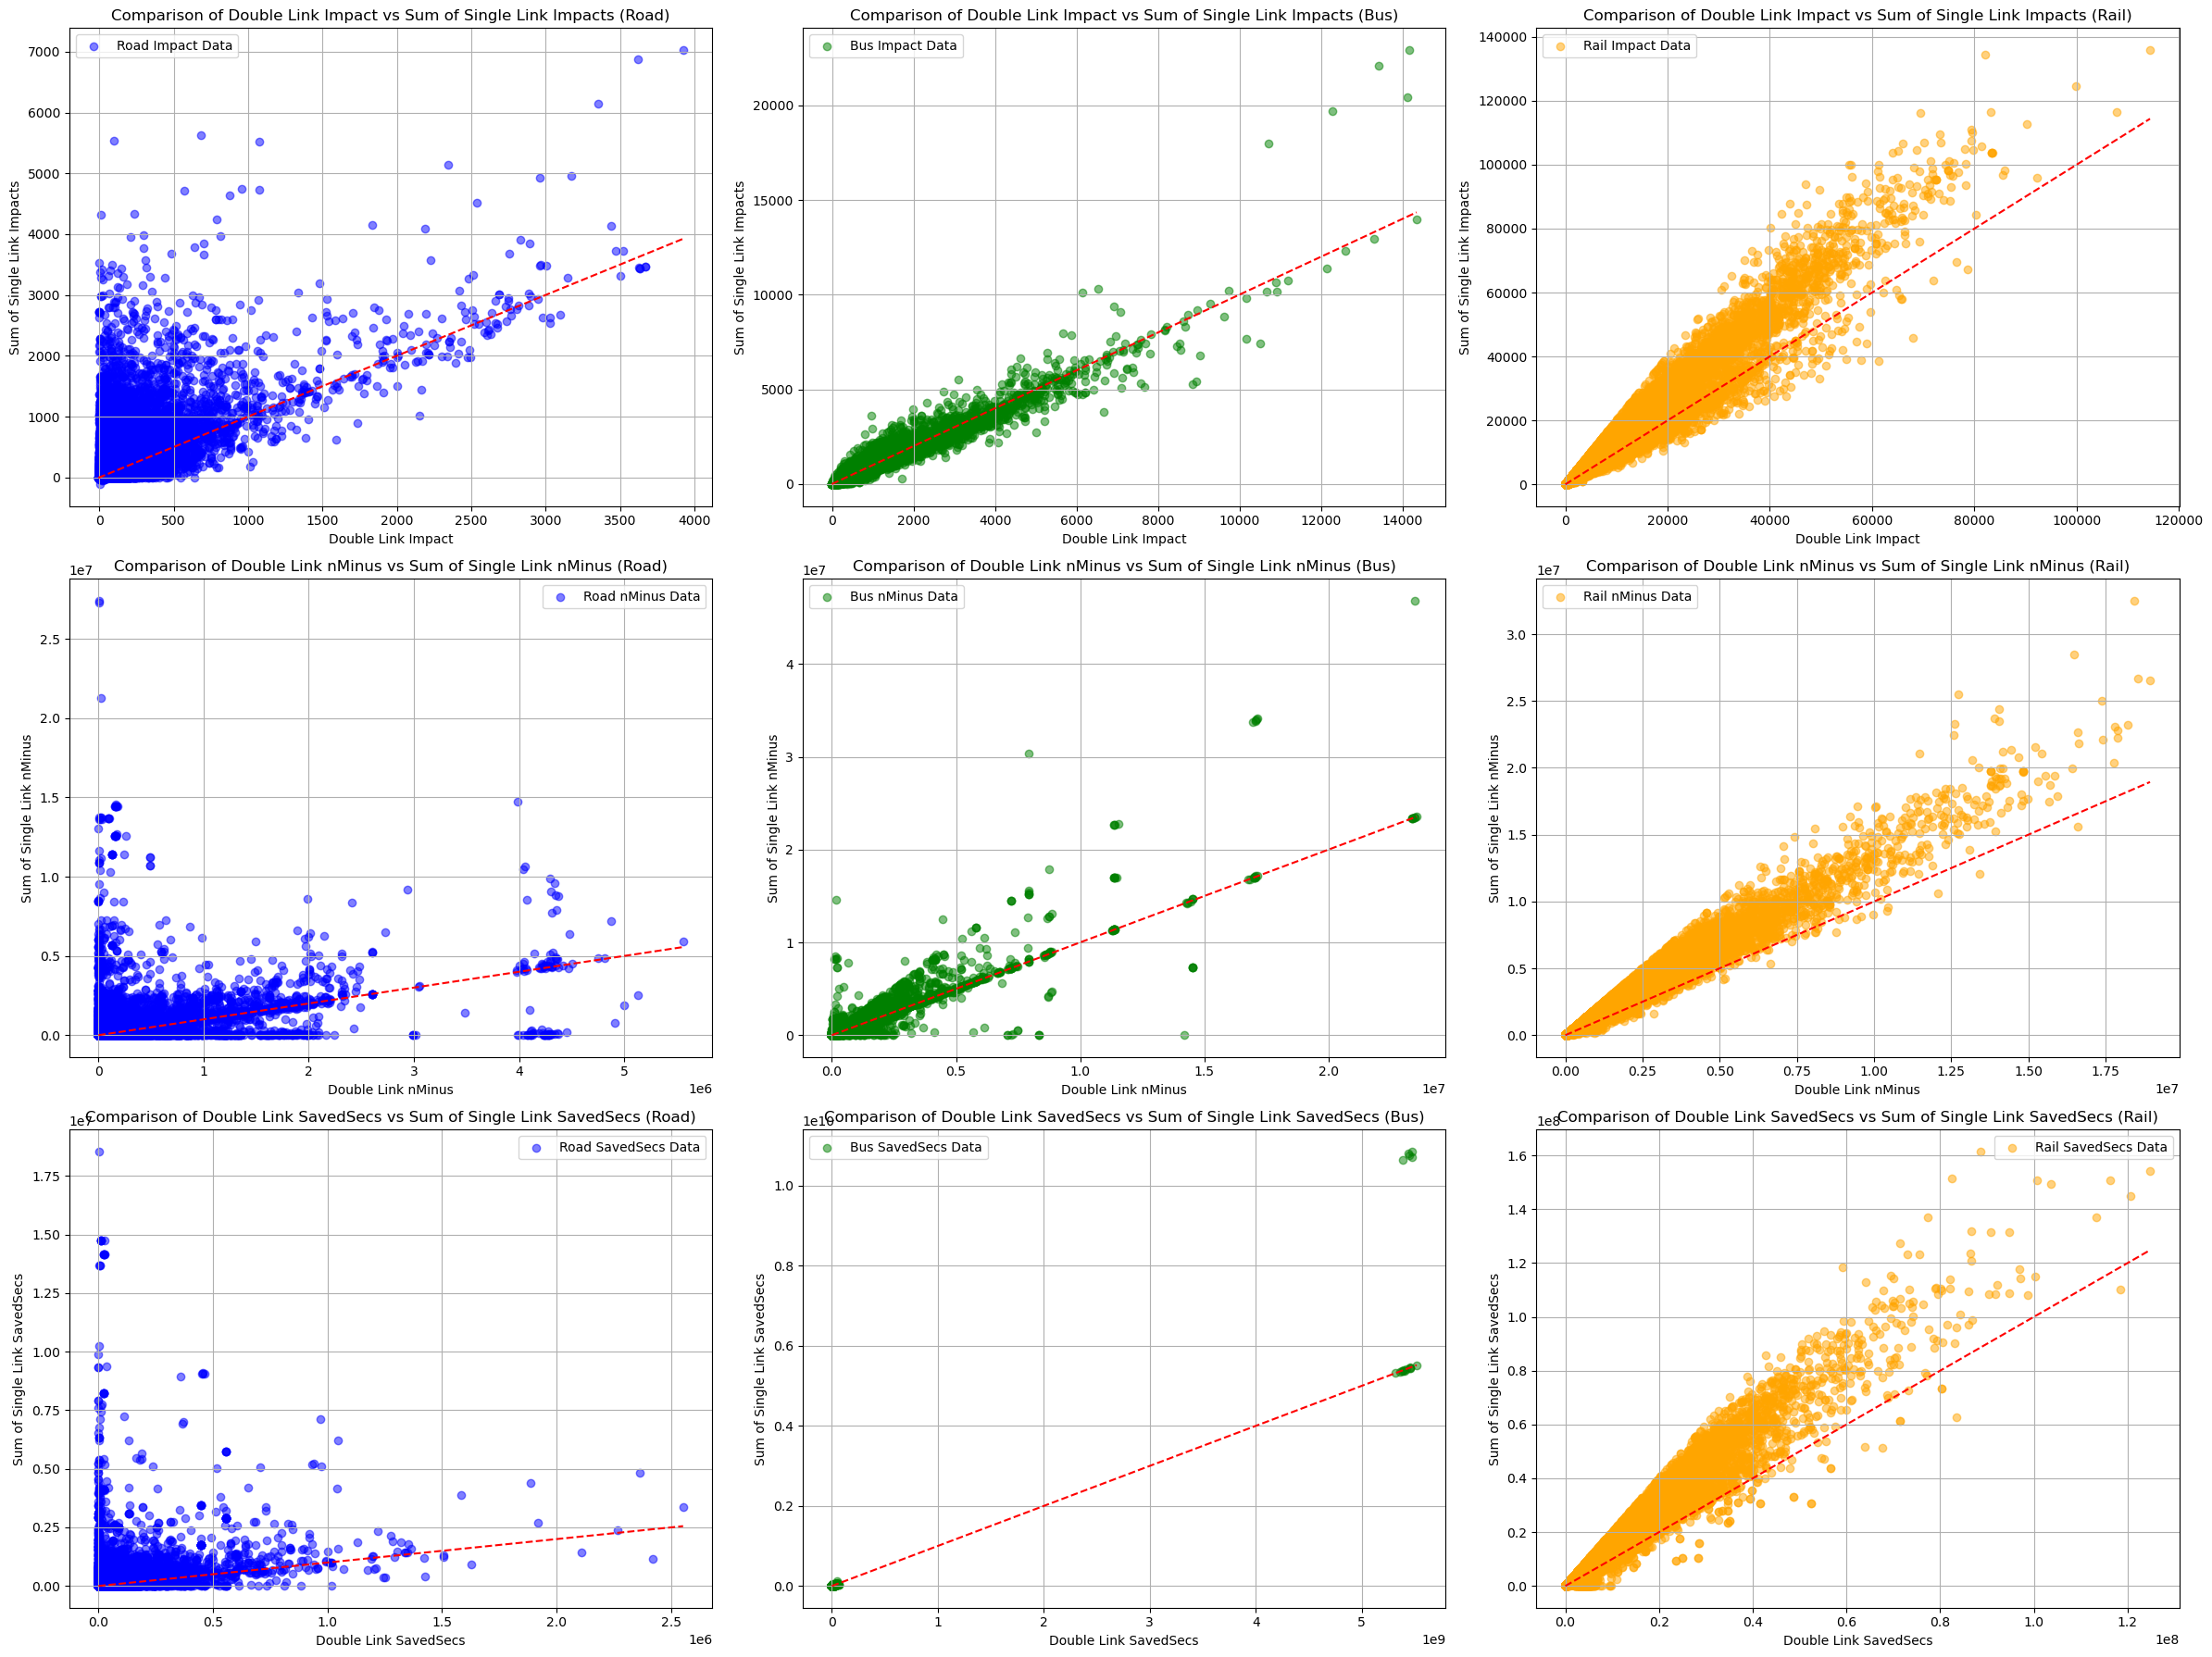

In [7]:
# Plotted entirely with raw data, no extreme value filtering


import pandas as pd
import matplotlib.pyplot as plt

output_file = r"C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\ScenarioData\single_vs_double_links_results_1.csv"
df = pd.read_csv(output_file)

df['single_impact_sum'] = df['single_impact_1'] + df['single_impact_2']
df['single_nminus_sum'] = df['single_nminus_1'] + df['single_nminus_2']
df['single_savedsecs_sum'] = df['single_savedsecs_1'] + df['single_savedsecs_2']

fig, axes = plt.subplots(3, 3, figsize=(24, 18))

modes = {0: 'Road', 1: 'Bus', 2: 'Rail'}
colors = {0: 'blue', 1: 'green', 2: 'orange'}

# Impact
for mode, label in modes.items():
    ax = axes[0, mode]
    mode_df = df[df['double_mode'] == mode]
    ax.scatter(mode_df['double_impact'], mode_df['single_impact_sum'], alpha=0.5, color=colors[mode], label=f'{label} Impact Data')
    ax.plot([mode_df['double_impact'].min(), mode_df['double_impact'].max()],
            [mode_df['double_impact'].min(), mode_df['double_impact'].max()],
            color='red', linestyle='--')
    ax.set_xlabel('Double Link Impact')
    ax.set_ylabel('Sum of Single Link Impacts')
    ax.set_title(f'Comparison of Double Link Impact vs Sum of Single Link Impacts ({label})')
    ax.legend()
    ax.grid(True)

# nMinus
for mode, label in modes.items():
    ax = axes[1, mode]
    mode_df = df[df['double_mode'] == mode]
    ax.scatter(mode_df['double_nminus'], mode_df['single_nminus_sum'], alpha=0.5, color=colors[mode], label=f'{label} nMinus Data')
    ax.plot([mode_df['double_nminus'].min(), mode_df['double_nminus'].max()],
            [mode_df['double_nminus'].min(), mode_df['double_nminus'].max()],
            color='red', linestyle='--')
    ax.set_xlabel('Double Link nMinus')
    ax.set_ylabel('Sum of Single Link nMinus')
    ax.set_title(f'Comparison of Double Link nMinus vs Sum of Single Link nMinus ({label})')
    ax.legend()
    ax.grid(True)

# SavedSecs
for mode, label in modes.items():
    ax = axes[2, mode]
    mode_df = df[df['double_mode'] == mode]
    ax.scatter(mode_df['double_savedsecs'], mode_df['single_savedsecs_sum'], alpha=0.5, color=colors[mode], label=f'{label} SavedSecs Data')
    ax.plot([mode_df['double_savedsecs'].min(), mode_df['double_savedsecs'].max()],
            [mode_df['double_savedsecs'].min(), mode_df['double_savedsecs'].max()],
            color='red', linestyle='--')
    ax.set_xlabel('Double Link SavedSecs')
    ax.set_ylabel('Sum of Single Link SavedSecs')
    ax.set_title(f'Comparison of Double Link SavedSecs vs Sum of Single Link SavedSecs ({label})')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


d:\Software\anaconda\envs\geospatial\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Software\anaconda\envs\geospatial\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


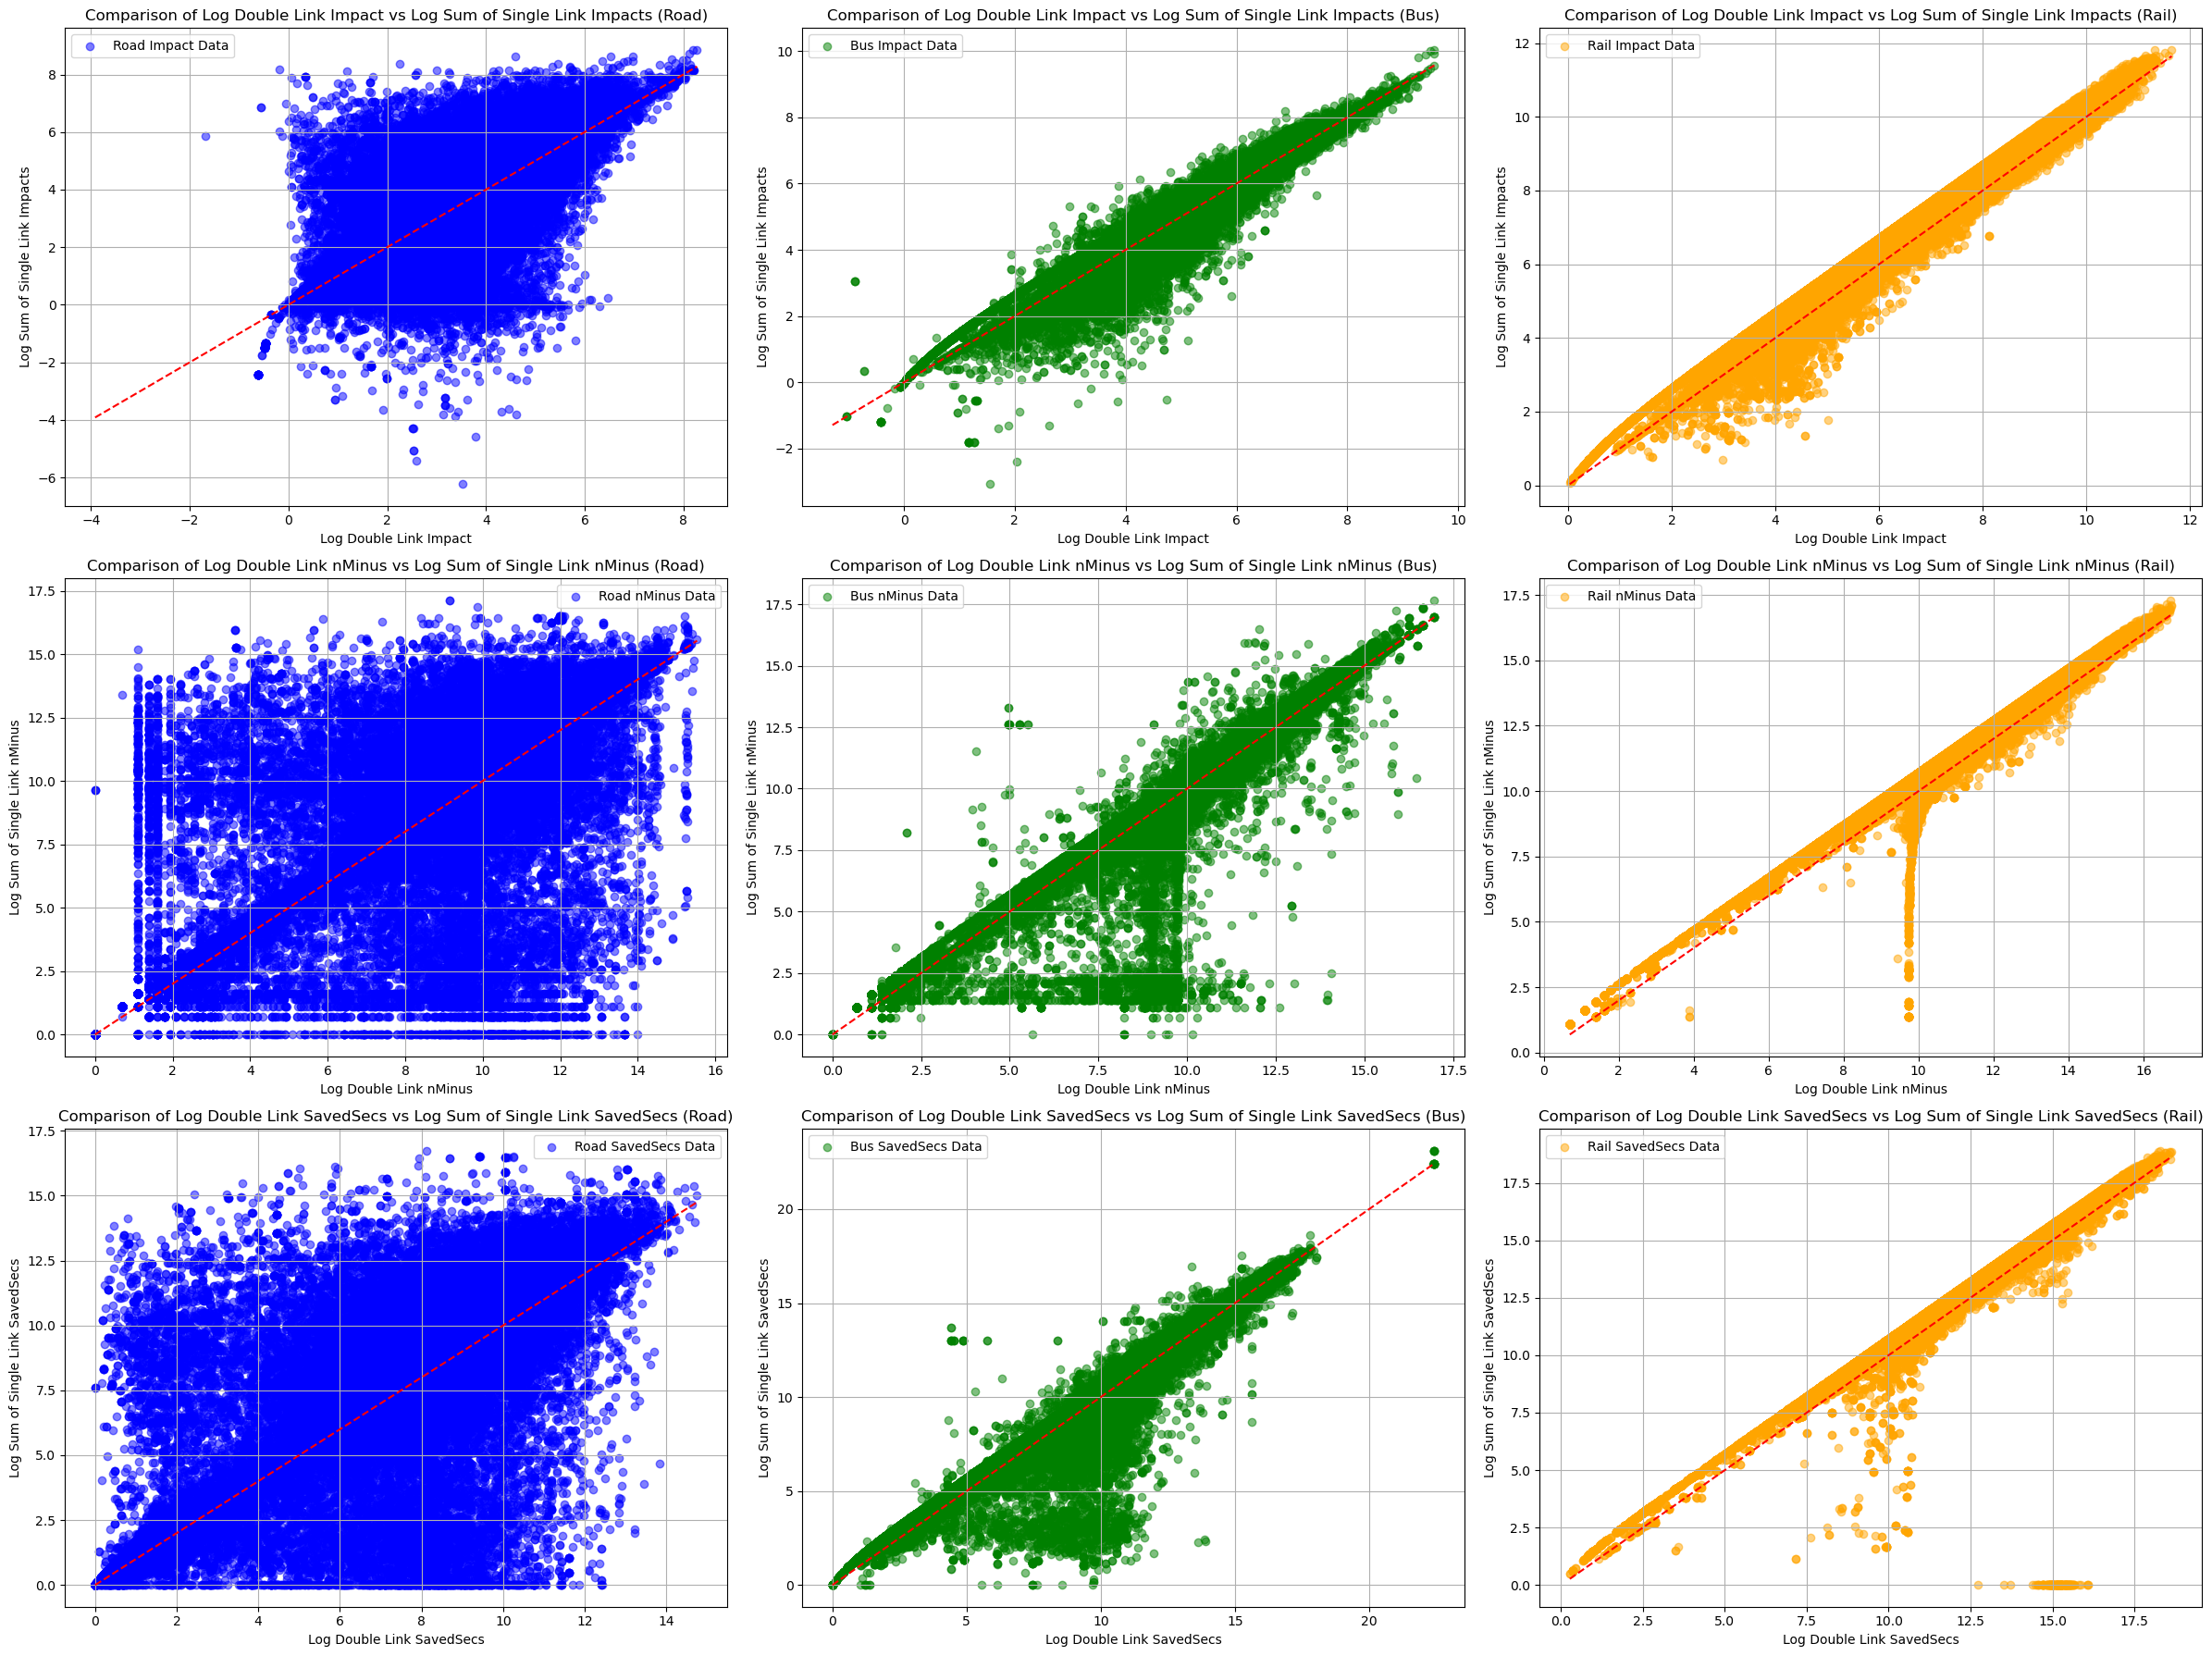

In [1]:
# Use logarithmic transformation, no filtering

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

output_file = r"C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\ScenarioData\single_vs_double_links_results_1.csv"
df = pd.read_csv(output_file)

# Adding combined columns for sum calculations
df['single_impact_sum'] = df['single_impact_1'] + df['single_impact_2']
df['single_nminus_sum'] = df['single_nminus_1'] + df['single_nminus_2']
df['single_savedsecs_sum'] = df['single_savedsecs_1'] + df['single_savedsecs_2']

# Apply log transformation to avoid issues with zero values
df['log_double_impact'] = np.log1p(df['double_impact'])
df['log_single_impact_sum'] = np.log1p(df['single_impact_sum'])
df['log_double_nminus'] = np.log1p(df['double_nminus'])
df['log_single_nminus_sum'] = np.log1p(df['single_nminus_sum'])
df['log_double_savedsecs'] = np.log1p(df['double_savedsecs'])
df['log_single_savedsecs_sum'] = np.log1p(df['single_savedsecs_sum'])

fig, axes = plt.subplots(3, 3, figsize=(24, 18))

modes = {0: 'Road', 1: 'Bus', 2: 'Rail'}
colors = {0: 'blue', 1: 'green', 2: 'orange'}

# Impact
for mode, label in modes.items():
    ax = axes[0, mode]
    mode_df = df[df['double_mode'] == mode]
    ax.scatter(mode_df['log_double_impact'], mode_df['log_single_impact_sum'], alpha=0.5, color=colors[mode], label=f'{label} Impact Data')
    ax.plot([mode_df['log_double_impact'].min(), mode_df['log_double_impact'].max()],
            [mode_df['log_double_impact'].min(), mode_df['log_double_impact'].max()],
            color='red', linestyle='--')
    ax.set_xlabel('Log Double Link Impact')
    ax.set_ylabel('Log Sum of Single Link Impacts')
    ax.set_title(f'Comparison of Log Double Link Impact vs Log Sum of Single Link Impacts ({label})')
    ax.legend()
    ax.grid(True)

# nMinus
for mode, label in modes.items():
    ax = axes[1, mode]
    mode_df = df[df['double_mode'] == mode]
    ax.scatter(mode_df['log_double_nminus'], mode_df['log_single_nminus_sum'], alpha=0.5, color=colors[mode], label=f'{label} nMinus Data')
    ax.plot([mode_df['log_double_nminus'].min(), mode_df['log_double_nminus'].max()],
            [mode_df['log_double_nminus'].min(), mode_df['log_double_nminus'].max()],
            color='red', linestyle='--')
    ax.set_xlabel('Log Double Link nMinus')
    ax.set_ylabel('Log Sum of Single Link nMinus')
    ax.set_title(f'Comparison of Log Double Link nMinus vs Log Sum of Single Link nMinus ({label})')
    ax.legend()
    ax.grid(True)

# SavedSecs
for mode, label in modes.items():
    ax = axes[2, mode]
    mode_df = df[df['double_mode'] == mode]
    ax.scatter(mode_df['log_double_savedsecs'], mode_df['log_single_savedsecs_sum'], alpha=0.5, color=colors[mode], label=f'{label} SavedSecs Data')
    ax.plot([mode_df['log_double_savedsecs'].min(), mode_df['log_double_savedsecs'].max()],
            [mode_df['log_double_savedsecs'].min(), mode_df['log_double_savedsecs'].max()],
            color='red', linestyle='--')
    ax.set_xlabel('Log Double Link SavedSecs')
    ax.set_ylabel('Log Sum of Single Link SavedSecs')
    ax.set_title(f'Comparison of Log Double Link SavedSecs vs Log Sum of Single Link SavedSecs ({label})')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


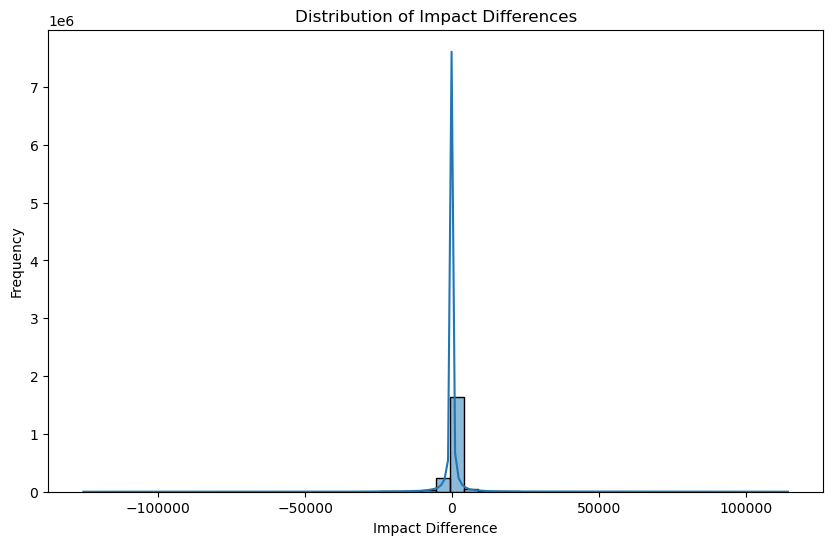

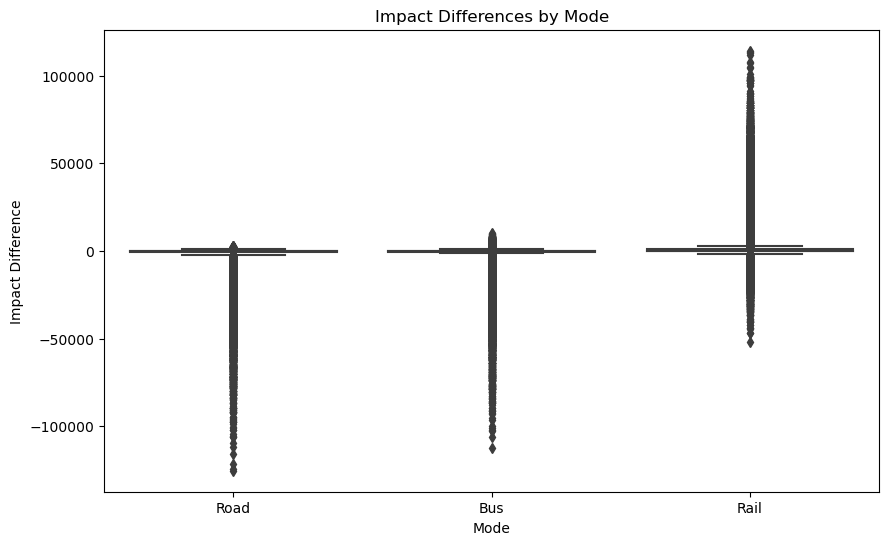

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

output_file = r"C:\Users\Xinyi Liu\OneDrive - University College London\Research Assistant\NEW Quant AI\DAFNI\ScenarioData\single_vs_double_links_results.csv"
results_df = pd.read_csv(output_file)

# Plot the difference
plt.figure(figsize=(10, 6))
sns.histplot(results_df['impact_difference'].dropna(), bins=50, kde=True)
plt.xlabel('Impact Difference')
plt.ylabel('Frequency')
plt.title('Distribution of Impact Differences')
plt.show()

# differences by mode
plt.figure(figsize=(10, 6))
sns.boxplot(x='double_mode', y='impact_difference', data=results_df)
plt.xlabel('Mode')
plt.ylabel('Impact Difference')
plt.title('Impact Differences by Mode')
plt.xticks(ticks=[0, 1, 2], labels=['Road', 'Bus', 'Rail'])
plt.show()
